In [1]:
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import mpmp.config as cfg
import mpmp.utilities.analysis_utilities as au
import mpmp.utilities.data_utilities as du
import mpmp.utilities.plot_utilities as plu

%load_ext autoreload
%autoreload 2

In [2]:
# location of classification results
results_dir = Path(cfg.results_dirs['mutation'], 'merged_all', 'gene').resolve()

# set significance cutoff after FDR correction
SIG_ALPHA = 0.001

### Load results and perform statistical testing/correction

In [3]:
# load raw data
results_df = au.load_stratified_prediction_results(results_dir, 'gene')

# here we want to use compressed data for methylation datasets (27k and 450k)
# the results in 02_classify_compressed/compressed_vs_raw_results.ipynb show that
# performance is equal or slightly better for PCA compressed methylation data,
# and it's much easier/faster to fit models on
results_df = results_df[results_df.training_data.isin(['expression', 'rppa', 'mirna', 'mut_sigs'])]

# make sure that we're correctly pointing to raw data for non-methylation data types
# and that we have data for two replicates (two random seeds)
print(results_df.shape)
print(results_df.seed.unique())
print(results_df.training_data.unique())
results_df.head()

(41376, 9)
[42  1]
['expression' 'mirna' 'rppa' 'mut_sigs']


,auroc,aupr,identifier,training_data,signal,seed,data_type,fold,experiment
0,0.89764,0.716580,MAP3K1,expression,signal,42,train,0,gene
1,0.44982,0.075833,MAP3K1,expression,signal,42,test,0,gene
2,0.66546,0.300290,MAP3K1,expression,signal,42,cv,0,gene
3,0.98281,0.909130,MAP3K1,expression,signal,42,train,1,gene
4,0.85560,0.564490,MAP3K1,expression,signal,42,test,1,gene


In [4]:
# load compressed data for me_27k and me_450k
compressed_results_df = au.load_compressed_prediction_results(results_dir, 'gene')

# make sure that we're correctly pointing to compressed methylation data
# and that we have data for one dimension and two replicates (two random seeds)
print(compressed_results_df.shape)
print(compressed_results_df.seed.unique())
print(compressed_results_df.training_data.unique())
print(compressed_results_df.n_dims.unique())
compressed_results_df.head()

(20688, 10)
[ 1 42]
['me_450k' 'me_27k']
[5000]


,auroc,aupr,identifier,training_data,signal,seed,data_type,fold,n_dims,experiment
0,1.00000,1.00000,MAP3K1,me_450k,signal,1,train,0,5000,gene
1,0.81326,0.45134,MAP3K1,me_450k,signal,1,test,0,5000,gene
2,0.65695,0.28388,MAP3K1,me_450k,signal,1,cv,0,5000,gene
3,1.00000,1.00000,MAP3K1,me_450k,signal,1,train,1,5000,gene
4,0.73856,0.45058,MAP3K1,me_450k,signal,1,test,1,5000,gene


In [5]:
results_df['n_dims'] = 'raw'
results_df = pd.concat((results_df, compressed_results_df))
print(results_df.seed.unique())
print(results_df.training_data.unique())
print(results_df.n_dims.unique())
print(results_df.shape)
training_data_map = {
    'expression': 'gene expression',
    'me_27k': '27k methylation',
    'me_450k': '450k methylation',
    'rppa': 'RPPA',
    'mirna': 'microRNA',
    'mut_sigs': 'mutational signatures',
}
results_df.training_data.replace(to_replace=training_data_map, inplace=True)
results_df.head()

[42  1]
['expression' 'mirna' 'rppa' 'mut_sigs' 'me_450k' 'me_27k']
['raw' 5000]
(62064, 10)


,auroc,aupr,identifier,training_data,signal,seed,data_type,fold,experiment,n_dims
0,0.89764,0.716580,MAP3K1,gene expression,signal,42,train,0,gene,raw
1,0.44982,0.075833,MAP3K1,gene expression,signal,42,test,0,gene,raw
2,0.66546,0.300290,MAP3K1,gene expression,signal,42,cv,0,gene,raw
3,0.98281,0.909130,MAP3K1,gene expression,signal,42,train,1,gene,raw
4,0.85560,0.564490,MAP3K1,gene expression,signal,42,test,1,gene,raw


In [6]:
all_results_df = au.compare_all_data_types(results_df,
                                           SIG_ALPHA,
                                           metric='aupr')

cfg.sig_genes_dir.mkdir(exist_ok=True)
all_results_df.to_csv(cfg.sig_genes_all, index=False, sep='\t')

all_results_df.sort_values(by='p_value').head(10)

,gene,delta_mean,p_value,corr_pval,reject_null,training_data,nlog10_p
23,BRAF,0.308046,6.123121e-10,1.328717e-07,True,27k methylation,6.876567
45,CIC,0.647034,1.880651e-09,4.081014e-07,True,450k methylation,6.389232
60,ERBB2,0.312735,2.905854e-09,3.152852e-07,True,27k methylation,6.501296
45,CIC,0.645135,3.558277e-09,7.721461e-07,True,gene expression,6.112301
56,EGFR,0.531508,9.779722e-09,8.999793e-07,True,gene expression,6.045767
60,ERBB2,0.537138,1.339592e-08,8.999793e-07,True,gene expression,6.045767
168,PTEN,0.229569,1.460109e-08,1.056146e-06,True,27k methylation,5.976276
207,TSC1,0.616890,1.745741e-08,8.999793e-07,True,gene expression,6.045767
30,CCND1,0.603684,2.073685e-08,8.999793e-07,True,gene expression,6.045767
204,TP53,0.202256,3.084420e-08,6.693192e-06,True,RPPA,5.174367


### Load gene sets

In [7]:
# load datasets
vogelstein_df = du.load_vogelstein()
vogelstein_df.head()

,gene,Gene Name,# Mutated Tumor Samples**,Ocogene score*,Tumor Suppressor Gene score*,classification,Core pathway,Process
0,ABL1,"c-abl oncogene 1, receptor tyrosine kinase",851,0.926904,0.003046,Oncogene,Cell Cycle/Apoptosis,Cell Survival
1,ACVR1B,"activin A receptor, type IB",17,0.000000,0.423077,TSG,TGF-b,Cell Survival
2,AKT1,v-akt murine thymoma viral oncogene homolog 1,155,0.929487,0.006410,Oncogene,PI3K,Cell Survival
3,ALK,anaplastic lymphoma receptor tyrosine kinase,189,0.720000,0.010000,Oncogene,PI3K; RAS,Cell Survival
4,APC,adenomatous polyposis coli,2561,0.024553,0.917222,TSG,APC,Cell Fate


In [8]:
# load datasets
merged_df = du.load_merged()
merged_df.head()

,gene,classification
0,ABI1,TSG
1,ABL1,Oncogene
2,ABL2,Oncogene
3,ACKR3,Oncogene
4,ACVR1,Oncogene


In [9]:
vogelstein_genes = set(vogelstein_df.gene)
non_vogelstein_genes = set(merged_df.gene) - vogelstein_genes
print(len(vogelstein_genes), len(non_vogelstein_genes))

125 386


### Plot results for Vogelstein and non-Vogelstein genes separately

gene expression: 34/75
27k methylation: 22/75
450k methylation: 26/75


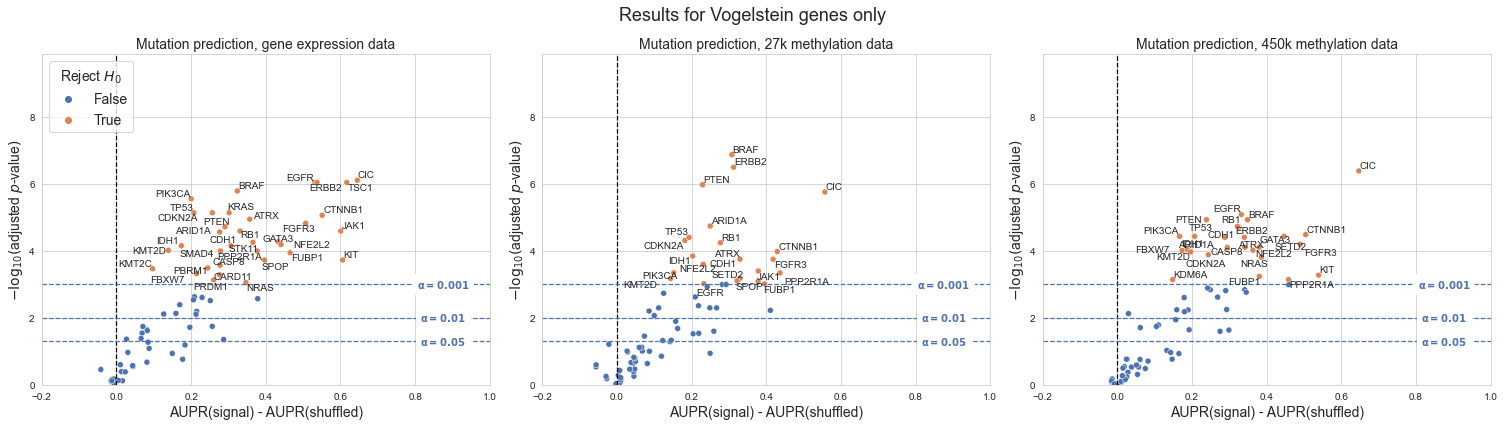

In [10]:
sns.set({'figure.figsize': (21, 6)})
sns.set_style('whitegrid')

fig, axarr = plt.subplots(1, 3)

# plot mutation prediction from expression, in a volcano-like plot
datasets = ['gene expression', '27k methylation', '450k methylation']
filtered_data_map = {k: v for k, v in training_data_map.items() if v in datasets}

plu.plot_volcano_baseline(all_results_df[all_results_df.gene.isin(vogelstein_genes)],
                          axarr,
                          filtered_data_map,
                          SIG_ALPHA,
                          metric='aupr',
                          verbose=True)

plt.suptitle('Results for Vogelstein genes only', size=18)
plt.tight_layout()

gene expression: 45/142
27k methylation: 9/142
450k methylation: 16/142


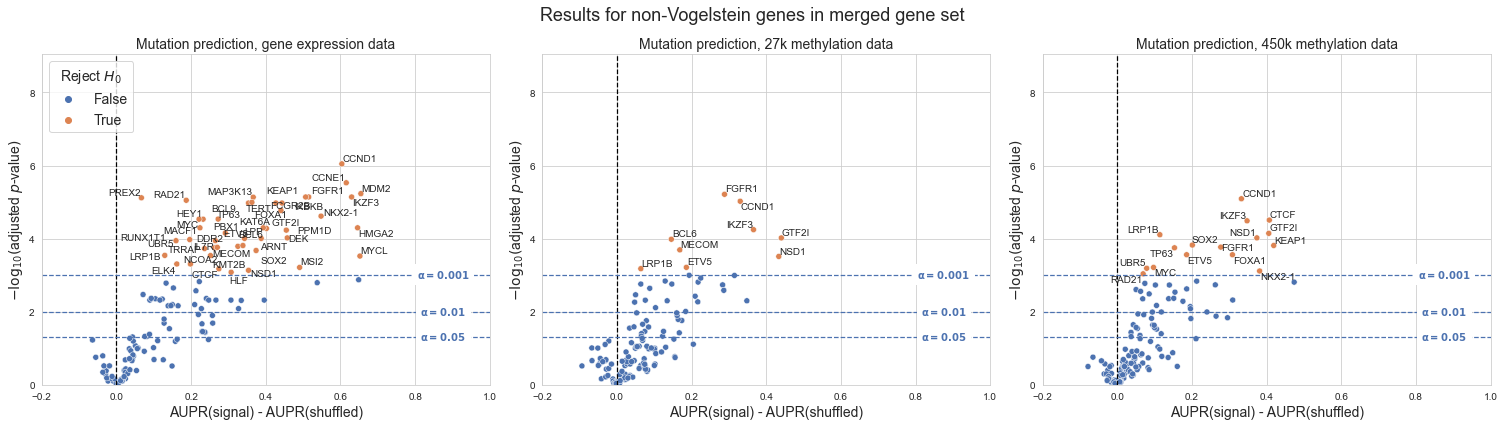

In [11]:
sns.set({'figure.figsize': (21, 6)})
sns.set_style('whitegrid')

fig, axarr = plt.subplots(1, 3)

# plot mutation prediction from expression, in a volcano-like plot
datasets = ['gene expression', '27k methylation', '450k methylation']
filtered_data_map = {k: v for k, v in training_data_map.items() if v in datasets}

plu.plot_volcano_baseline(all_results_df[all_results_df.gene.isin(non_vogelstein_genes)],
                          axarr,
                          filtered_data_map,
                          SIG_ALPHA,
                          metric='aupr',
                          verbose=True)

plt.suptitle('Results for non-Vogelstein genes in merged gene set', size=18)
plt.tight_layout()

### Explore results for DNA damage repair genes

In [12]:
# this list of genes in DDR pathways comes from Table S1 in Knijnenburg et al. 2018
# https://doi.org/10.1016/j.celrep.2018.03.076
ddr_genes_df = pd.read_excel(
    cfg.data_dir / 'mmc2.xlsx',
    skiprows = 3
)

print(ddr_genes_df.shape)
ddr_genes_df.head()

(276, 29)


,Entrez Gene ID,Gene Symbol,Gene Description,Alias (selected),Additional Comments,Match type,Approved symbol,Approved name,HGNC ID,Location,...,Others,Base Excision Repair (BER).1,"Nucleotide Excision Repair (NER, including TC-NER and GC-NER))",Mismatch Repair (MMR).1,Fanconi Anemia (FA).1,Homologous Recomination (HR),Non-homologous End Joining (NHEJ).1,Direct Repair (DR).1,Translesion Synthesis (TLS).1,Damage Sensor etc.
0,200558,APLF,aprataxin and PNKP like factor,NaN,NaN,Approved symbol,APLF,aprataxin and PNKP like factor,HGNC:28724,2p13.3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,54840,APTX,aprataxin,"AOA, AOA1, AXA1, EAOH, EOAHA, FHA-HIT",NaN,Approved symbol,APTX,aprataxin,HGNC:15984,9p21.1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,10973,ASCC3,activating signal cointegrator 1 complex subun...,NaN,NaN,Approved symbol,ASCC3,activating signal cointegrator 1 complex subun...,HGNC:18697,6q16.3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1791,DNTT,DNA nucleotidylexotransferase,NaN,NaN,Approved symbol,DNTT,DNA nucleotidylexotransferase,HGNC:2983,10q24.1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,3978,LIG1,DNA ligase 1,NaN,NaN,Approved symbol,LIG1,DNA ligase 1,HGNC:6598,19q13.33,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [13]:
ddr_genes = set(ddr_genes_df['Gene Symbol'])
ddr_vogelstein_genes = ddr_genes.intersection(vogelstein_genes)
print(len(ddr_vogelstein_genes))
print(ddr_vogelstein_genes)

11
{'BRCA1', 'BRCA2', 'IDH1', 'MSH2', 'MSH6', 'MLH1', 'ATRX', 'ATM', 'PTEN', 'TP53', 'SMARCA4'}


In [14]:
ddr_non_vogelstein_genes = ddr_genes.intersection(non_vogelstein_genes)
print(len(ddr_non_vogelstein_genes))
print(ddr_non_vogelstein_genes)

15
{'POLE', 'ERCC2', 'RAD51B', 'CHEK2', 'PMS2', 'POLD1', 'RMI2', 'BARD1', 'YWHAE', 'ATR', 'PER1', 'PMS1', 'POLQ', 'CUL3', 'MSH3'}


In [15]:
print(ddr_vogelstein_genes.union(ddr_non_vogelstein_genes))
ddr_df = all_results_df[all_results_df.gene.isin(ddr_vogelstein_genes.union(
                                                  ddr_non_vogelstein_genes))]
print(ddr_df.gene.unique())

{'BRCA1', 'POLE', 'BRCA2', 'MSH2', 'MSH6', 'ERCC2', 'RAD51B', 'PMS2', 'MLH1', 'ATRX', 'ATM', 'POLD1', 'PTEN', 'TP53', 'PER1', 'POLQ', 'IDH1', 'CHEK2', 'RMI2', 'BARD1', 'YWHAE', 'ATR', 'SMARCA4', 'PMS1', 'CUL3', 'MSH3'}
['ATM' 'ATR' 'ATRX' 'BRCA2' 'ERCC2' 'IDH1' 'POLE' 'POLQ' 'PTEN' 'SMARCA4'
 'TP53']


gene expression: 4/11
27k methylation: 4/11
450k methylation: 4/11


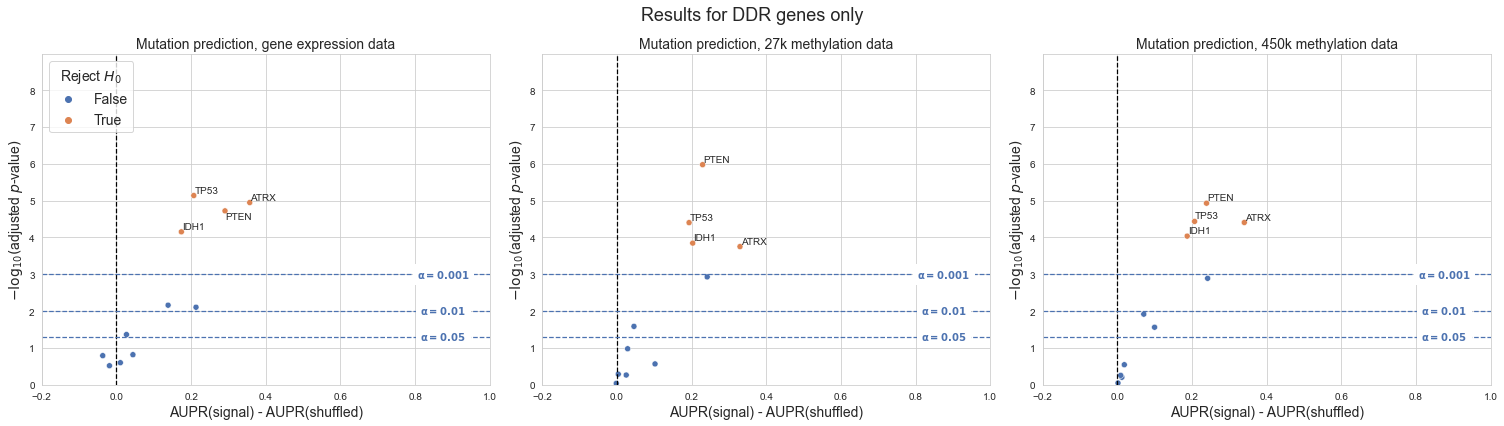

In [16]:
sns.set({'figure.figsize': (21, 6)})
sns.set_style('whitegrid')

fig, axarr = plt.subplots(1, 3)

# plot mutation prediction from expression, in a volcano-like plot
datasets = ['gene expression', '27k methylation', '450k methylation']
filtered_data_map = {k: v for k, v in training_data_map.items() if v in datasets}

plu.plot_volcano_baseline(all_results_df[
                              all_results_df.gene.isin(ddr_vogelstein_genes.union(
                                                       ddr_non_vogelstein_genes))
                          ],
                          axarr,
                          filtered_data_map,
                          SIG_ALPHA,
                          metric='aupr',
                          verbose=True)

plt.suptitle('Results for DDR genes only', size=18)
plt.tight_layout()